<a href="https://colab.research.google.com/github/pankaj8blr/Convolutional-Neural-Networks/blob/main/CNN_Assg_Waste_Segregation_14thApr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [2]:
# Import essential libraries

import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import pandas as pd
import gdown
import zipfile
import os
# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')




Load the dataset.

In [3]:
import gdown

file_id = "1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM"
zip_path = "data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", zip_path, quiet=False)

import zipfile
import os

extract_dir = "/content/data"  # this is the typical working directory in Colab

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)



Downloading...
From (original): https://drive.google.com/uc?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM
From (redirected): https://drive.google.com/uc?id=1hvRavwRCDT_At-1Z-LjPTv4IRW7xOzkM&confirm=t&uuid=352f7994-0ae3-4781-a86d-760775d6f87d
To: /content/data.zip
100%|██████████| 501M/501M [00:06<00:00, 79.1MB/s]


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [4]:
# Create a function to load the raw images
def load_images_from_folders(base_dir):
    images = []
    labels = []
    for label in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, label)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_file)
                try:
                    img = Image.open(img_path).convert('RGB')
                    images.append(img)
                    labels.append(label)
                except:
                    continue
    return images, labels



#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [5]:
# Get the images and their labels
base_folder = os.path.join(extract_dir, 'data')  # Adjust if necessary
images, labels = load_images_from_folders(base_folder)


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

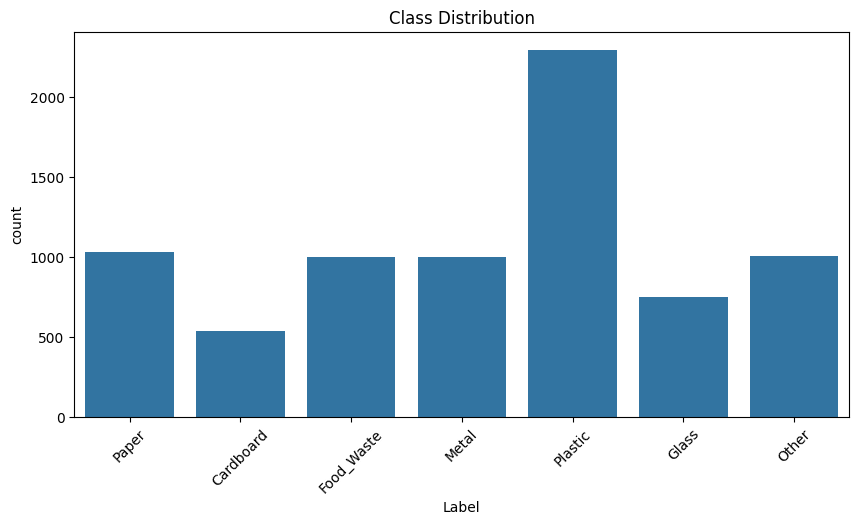

In [6]:
# Visualise Data Distribution
label_df = pd.DataFrame(labels, columns=['Label'])
plt.figure(figsize=(10,5))
sns.countplot(data=label_df, x='Label')
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()




##### Data has significant imbalance (e.g., Plastic has 4x more samples than cardboard, 3x more samples than Glass, approx 2.5x more samples than metal, paper etc.) #####

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

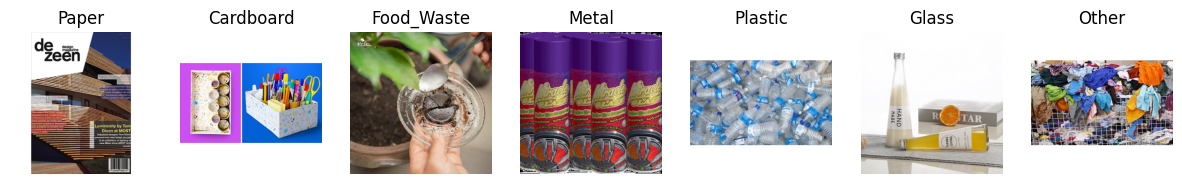

In [7]:
# Visualise Sample Images
def show_sample_images(images, labels, n=7):
    plt.figure(figsize=(15, 5))
    classes = list(set(labels))
    shown = set()
    count = 0
    for i, (img, lbl) in enumerate(zip(images, labels)):
        if lbl not in shown:
            plt.subplot(1, n, count+1)
            plt.imshow(img)
            plt.title(lbl)
            plt.axis('off')
            shown.add(lbl)
            count += 1
        if count == n:
            break
    plt.show()

show_sample_images(images, labels)



#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [8]:
# Find smallest and largest dimensions
widths, heights = zip(*(img.size for img in images))
print(f"Smallest image size: {min(widths)}x{min(heights)}")
print(f"Largest image size: {max(widths)}x{max(heights)}")



Smallest image size: 256x256
Largest image size: 256x256


In [9]:
# Resize the image dimensions
# Resize and preprocess
img_size = (128, 128)
resized_images = [img.resize(img_size) for img in images]
image_array = np.array([np.array(img) for img in resized_images]) / 255.0



### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [10]:
# Encode the labels suitably
# Encode the labels
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_cat = to_categorical(labels_encoded)



### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [11]:
# Assign specified parts of the dataset to train and validation sets
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(image_array, labels_cat, test_size=0.2, stratify=labels_encoded, random_state=42)



## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [12]:
# Build and compile CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,543 (12.61 MB)

 Trainable params: 3,305,543 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

In [13]:
import sys
print(f"Image array size: {sys.getsizeof(image_array)/1e6:.2f} MB")
print(f"Labels size: {sys.getsizeof(labels_cat)/1e6:.2f} MB")


Image array size: 2998.27 MB
Labels size: 0.00 MB


Use appropriate metrics and callbacks as needed.

In [14]:
# import dask.array as da
# from sklearn.model_selection import train_test_split

# image_array_dask = da.from_array(image_array, chunks=(1000, -1, -1, -1))  # adjust chunk size
# labels_cat_dask = da.from_array(labels_cat, chunks=(1000, -1))

# # Use Dask's train_test_split
# X_train, X_val, y_train, y_val = train_test_split(image_array_dask, labels_cat_dask, test_size=0.2, stratify=labels_encoded, random_state=42)

from sklearn.model_selection import train_test_split
import numpy as np

indices = np.arange(len(image_array))
train_idx, val_idx = train_test_split(indices, test_size=0.2, stratify=labels_encoded, random_state=42)

# Instead of copying data, access with indices
X_train = image_array[train_idx]
y_train = labels_cat[train_idx]
X_val = image_array[val_idx]
y_val = labels_cat[val_idx]



In [15]:
# Training
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), batch_size=16)



### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics
# Evaluate
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))


48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step
Classification Report:

              precision    recall  f1-score   support

   Cardboard       0.00      0.00      0.00       108
  Food_Waste       0.13      1.00      0.23       200
       Glass       0.00      0.00      0.00       150
       Metal       0.00      0.00      0.00       200
       Other       0.00      0.00      0.00       202
       Paper       0.00      0.00      0.00       206
     Plastic       0.00      0.00      0.00       459

    accuracy                           0.13      1525
   macro avg       0.02      0.14      0.03      1525
weighted avg       0.02      0.13      0.03      1525



### **Analysis on Classification Report**
1. Overall Performance

    Accuracy: 0.13 → This means the model is only correctly predicting 13% of the total test samples.

    Macro Avg F1-score: 0.03 → Indicates poor performance across all classes (averaged equally).

    Weighted Avg F1-score: 0.03 → Even when weighted by the number of samples in each class, the performance is still very poor

2. Class-wise Breakdown

    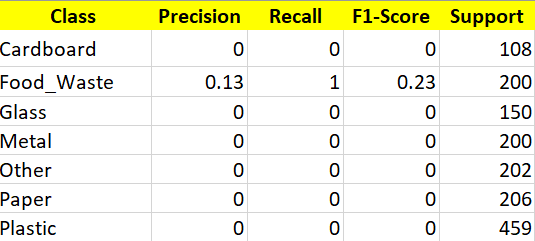

3. Key Observation:

    3.1 The model is predicting only one class (Food_Waste) for almost all inputs.

    3.2 This is evident from the 100% recall on Food_Waste but 0% recall for all other classes.

    3.3 It's a classic case of a collapsed model or severe class imbalance handling failure.

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [17]:
# Define augmentation steps to augment images

# Augmentation
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)




Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [18]:
# Create a function to augment the images
def create_augmented_generator(X, y, batch_size=32):
    return augmentor.flow(X, y, batch_size=batch_size)




In [19]:
# Create the augmented training dataset
augmented_train_gen = create_augmented_generator(X_train, y_train)



##### **4.1.2**

Train the model on the new augmented dataset.

In [20]:
# Train the model using augmented images
history_aug = model.fit(augmented_train_gen, epochs=10, validation_data=(X_val, y_val), steps_per_epoch=len(X_train)//32)


Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.2683 - loss: 1.9040 - val_accuracy: 0.3443 - val_loss: 1.6877
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.2188 - loss: 1.8164 - val_accuracy: 0.3462 - val_loss: 1.6815
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.3461 - loss: 1.6997 - val_accuracy: 0.3757 - val_loss: 1.5954
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.2500 - loss: 1.8201 - val_accuracy: 0.3744 - val_loss: 1.5867
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.3862 - loss: 1.6103 - val_accuracy: 0.4157 - val_loss: 1.5127
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 21s 108ms/step - accuracy: 0.4688 - loss: 1.5684 - val_accuracy: 0.4170 - val_loss: 1.5063
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 249s 1s/step - accuracy: 0.4033 - loss: 1.5491 - val_accuracy: 0.4203 - val_loss: 1.5472
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 22s 108ms/step - accuracy: 0.3750 - loss: 1.6679 - 

## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
    1. Data has significant imbalance (e.g., Plastic has 3x more samples than Glass, approx 2.5x more samples than metal, paper etc.), this can lead to biased training.

* Report model training results
    ##### **Analysis on Training done on the new augmented dataset** #####
    1. Improved Generalization
         Validation accuracy has increased from ~34% → 43%, showing that augmentation helped reduce overfitting and improved robustness.

    2. Consistent Drop in Validation Loss
        Validation loss decreased steadily from 1.68 to 1.47, indicating the model is learning meaningful patterns from augmented data.

    3. Narrower Gap Between Training & Validation Accuracy

        (i) No significant overfitting: training and validation accuracies are fairly close (good balance).

        (ii) Indicates that augmentation is preventing memorization and encouraging general learning.

#### **Areas for Further Improvement** ####
1. Inconsistent Training Accuracy

    (i) Training accuracy fluctuates (e.g., drops in Epoch 2 & 4), possibly due to
    
            a. Heavy augmentation

            b. Small batch size or learning rate instability

    (ii) We can sonsider using learning rate schedulers or less aggressive augmentations.

2. Plateauing Accuracy

    (i) Val accuracy flattens around 43–44% toward the end — model might be reaching its capacity.

    (ii) We can improve architecture or try transfer learning.

3. Class-Wise Impact Not Visible Yet

    While overall accuracy improved, it’s still important to check the confusion matrix and classification report to verify if all classes are now being predicted better — not just “Food_Waste”.